In [1]:
import pandas as pd
import numpy as np 
import itertools
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

### Preprocessing data

In [2]:
data_c = pd.read_parquet('./Local/2017_Clean/Combined.parquet')
data_f1 = pd.read_parquet('./Local/2017_Final/Combined_1.parquet')
data_f2 = pd.read_parquet('./Local/2017_Final/Combined_2.parquet')

datasets = {'Clean data': data_c, 'Final data 1': data_f1, 'Final data 2': data_f2}
matrices = {}

In [3]:
def preprocess_data(df):
    label_encoder = LabelEncoder()
    
    if 'Label' in df.columns:
        label_col = 'Label'
    elif ' Label' in df.columns:
        label_col = ' Label'
    else:
        raise ValueError("DataFrame does not contain a label column")
    
    df[label_col] = label_encoder.fit_transform(df[label_col])
    
    X = df.drop(label_col, axis=1)
    y = df[label_col]

    return X, y

processed_datasets = {name: preprocess_data(df) for name, df in datasets.items()}

### Running Random Forest for each dataset

In [4]:
for name, (X, y) in processed_datasets.items():
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    rfc = RandomForestClassifier()
    rfc.fit(X_train_scaled, y_train)

    y_pred_train = rfc.predict(X_train_scaled)
    y_pred_test = rfc.predict(X_test_scaled)
    
    print(f'--- {name} ---')
    print('Training Accuracy : ', metrics.accuracy_score(y_train, y_pred_train)*100)
    print('Validation Accuracy : ', metrics.accuracy_score(y_test, y_pred_test)*100)
    
    class_labels = y.unique()
    class_labels_str = [str(label) for label in class_labels]
    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred_test, target_names=class_labels_str))
    print('\n')

    cm = metrics.confusion_matrix(y_test, y_pred_test)
    matrices[name] = cm

--- Clean data ---
Training Accuracy :  99.93756413645127
Validation Accuracy :  99.86278686485478
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    429322
           2       0.91      0.66      0.76       408
          10       1.00      1.00      1.00     25511
           1       1.00      1.00      1.00      2025
           9       1.00      1.00      1.00     34698
          12       0.99      0.99      0.99      1017
          14       1.00      1.00      1.00      1113
          13       1.00      1.00      1.00      1182
           7       1.00      1.00      1.00         4
          11       1.00      0.57      0.73         7
           6       0.99      1.00      0.99     18185
           5       1.00      1.00      1.00       638
           4       0.70      0.87      0.78       289
           3       1.00      0.33      0.50         3
           8       0.35      0.15      0.21       126

    accuracy

### Visualization

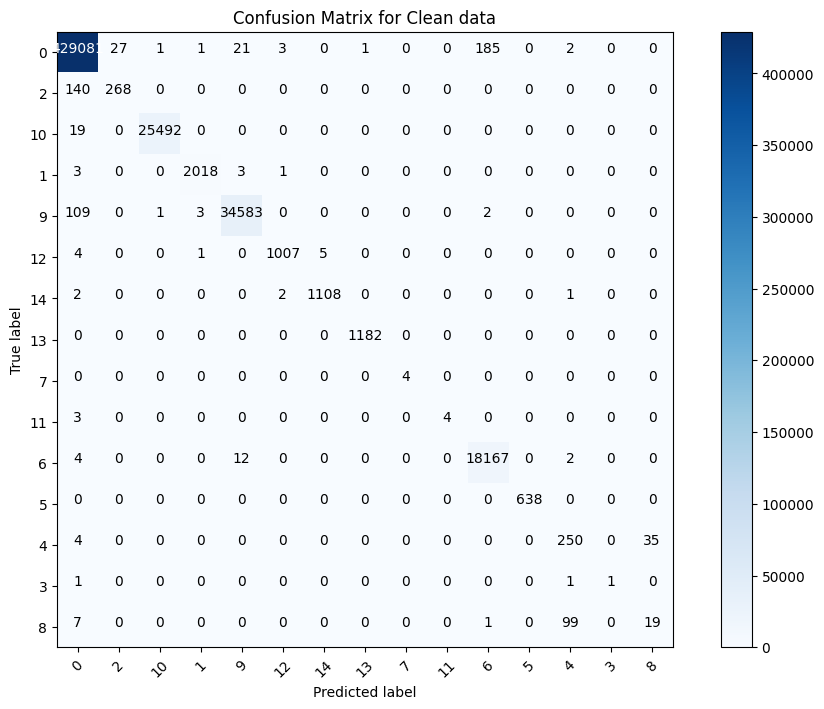

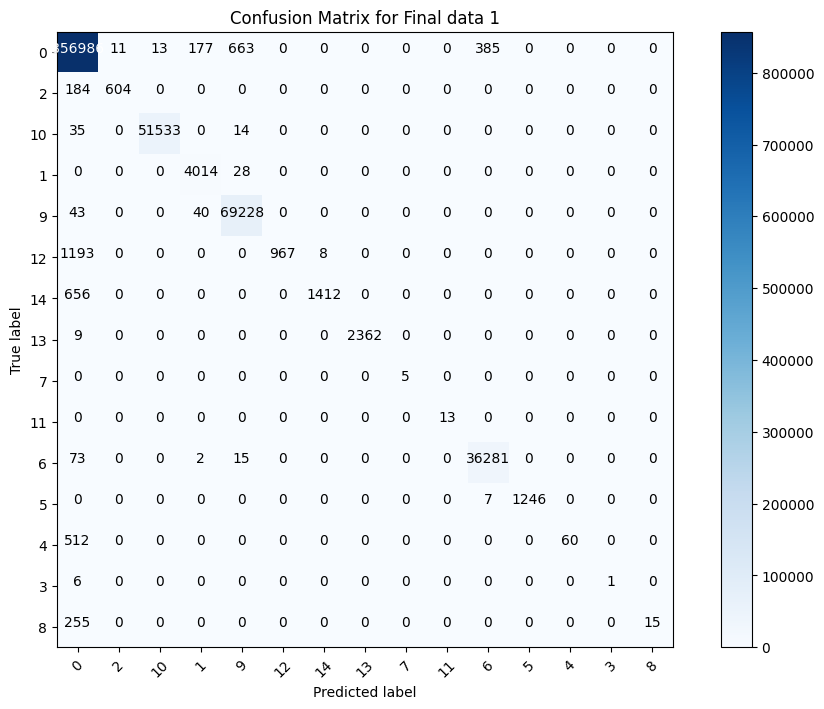

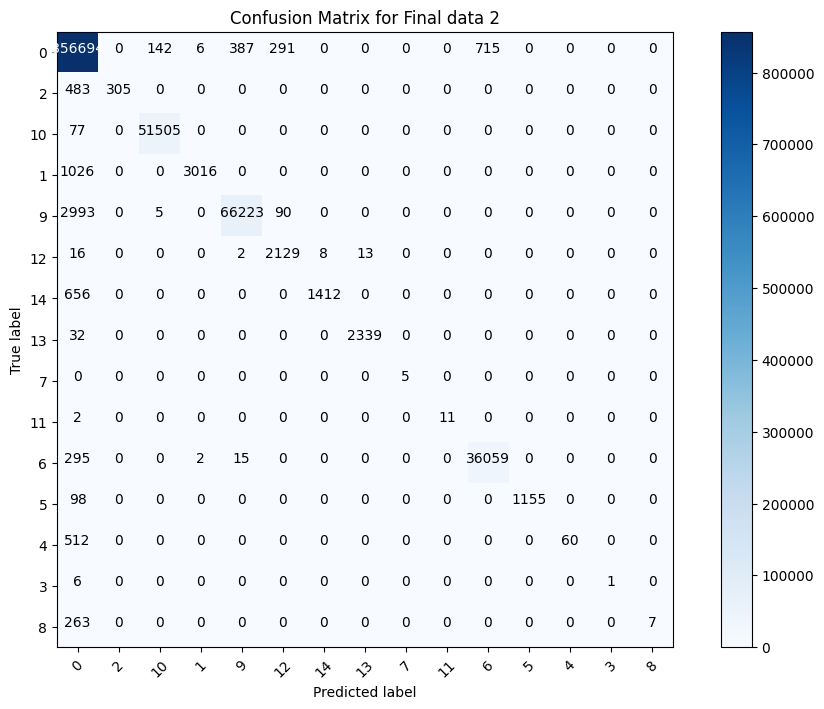

In [5]:
for name, matrix in matrices.items():
    plt.figure(figsize=(10, 7))
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.colorbar()
    
    tick_marks = np.arange(len(class_labels_str))
    plt.xticks(tick_marks, class_labels_str, rotation=45)
    plt.yticks(tick_marks, class_labels_str)

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()